#############################################################
           PART 1 (NAIVE_BAYES_CLASSIFICATION)               
#############################################################

 => Missing Data Handled......

 => Label Encoding Done......
-----------------------------
 Naive Bayes Classification :
-----------------------------
 => Accuracy in each fold: [49.77, 48.45, 47.05, 49.53, 47.21]

 => Average Accuracy after 5 fold CV: 48.4

 => Final test accuracy is 46.84

#############################################################
           PART 2 (PRINCIPLE COMPONENT ANALYSIS)             
#############################################################
---------------
 EIGEN VALUES :
---------------
[2.27007432 1.36353682 1.17800727 0.98400445 0.9412367  0.86486491
 0.67614541 0.44892311]

----------------
 EIGEN VECTORS :
----------------
[[-0.07493462 -0.55550984 -0.48468698 -0.32827027  0.22795508  0.10913091
   0.46005093  0.18153208 -0.18611003]
 [ 0.28169998  0.25320121 -0.

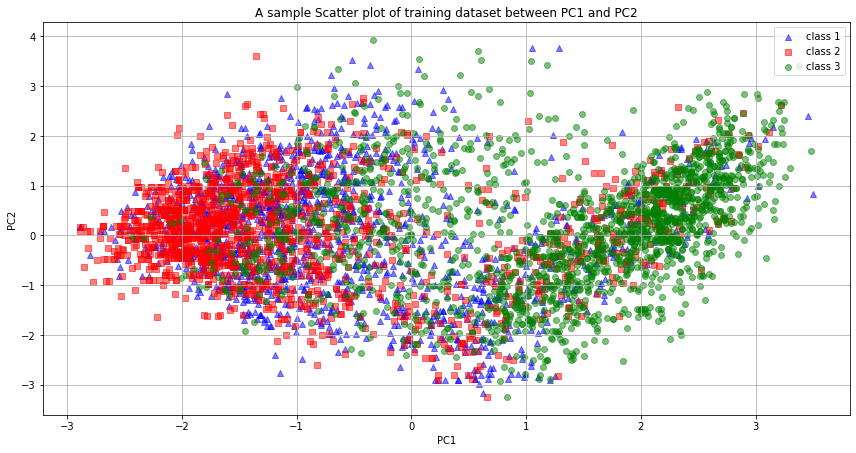

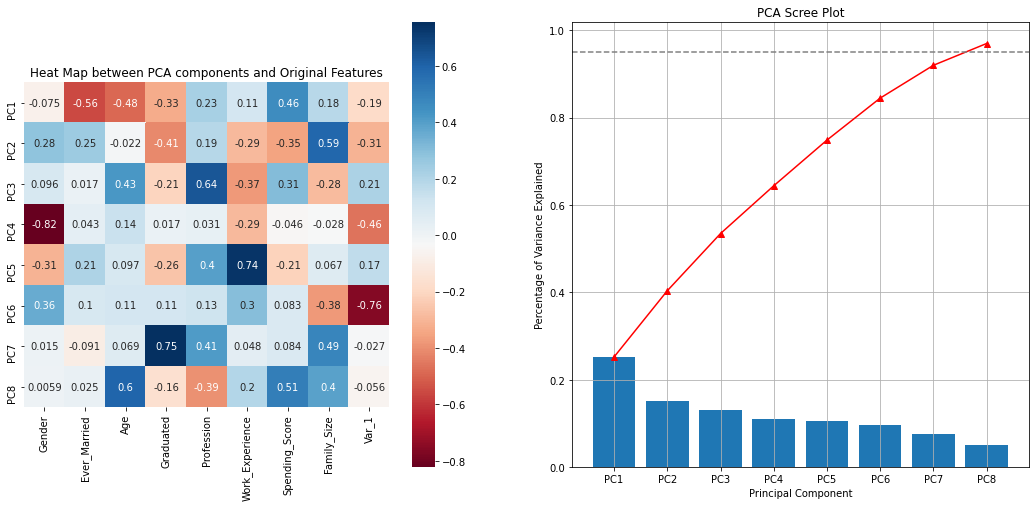

----------------------------------------------
 Naive Bayes Classification for PCA features :
----------------------------------------------
 => Accuracy in each fold: [49.77, 49.15, 49.69, 49.84, 48.22]

 => Average Accuracy after 5 fold CV: 49.33

 => Final test accuracy is 47.96

#############################################################
            PART 3 (SEQUENTIAL BACKWARD SELECTION)           
#############################################################

---------------------------------------------
 Number of outliers in the data removed = 143
---------------------------------------------

--------------------------------
 Sequential Backward Selection :
--------------------------------


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns

def splitdataset(balance_data): 
    # Splitting the dataset into train and test 
    train_set = balance_data.sample(frac=0.8)
    test_set = balance_data.drop(train_set.index)
    return train_set, test_set   


def det_type_of_feature(df):   
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]
            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    return feature_types

def handle_missing_data(df):
    for feature in df.columns:
          unique_values = df[feature].unique()
          example_value = unique_values[0]
          if isinstance(example_value, str):
                  imputer = SimpleImputer(missing_values = np.NaN, strategy='most_frequent')
                  df[feature] = imputer.fit_transform(df[feature].values.reshape(-1,1))[:,0]
          else:
                  imputer = SimpleImputer(missing_values = np.NaN, strategy='mean')
                  df[feature] = imputer.fit_transform(df[feature].values.reshape(-1,1))[:,0]
    print()    
    print(' => Missing Data Handled......')
    return df

def label_encoding(df):
    label_encoder = LabelEncoder()
    for feature in df.columns:
            unique_values = df[feature].unique()
            example_value = unique_values[0]
            if isinstance(example_value, str):
                df[feature] = label_encoder.fit_transform(df[feature])
    print()
    print(' => Label Encoding Done......')
    return df


def standardise_data(train_data, test_data):
    std_scaler = StandardScaler()
    train_data_temp = std_scaler.fit_transform(train_data.iloc[:, 0:9])
    test_data_temp = std_scaler.fit_transform(test_data.iloc[:, 0:9])
    X_train = train_data_temp
    y_train = train_data.iloc[:,-1]
    X_test = test_data_temp
    y_test = test_data.iloc[:,-1]
    return X_train, y_train, X_test, y_test      

def get_five_folds(dataset, no_of_folds):
    # splitting the data in folds
    dataset_split = list()
    n = int(dataset.shape[0])
    s = int(n/no_of_folds)
    for i in range(no_of_folds):
        part = i*s
        fold = dataset[part:part+s]
        dataset_split.append(fold)
    return dataset_split

def mean(numbers):
	return np.mean(numbers)
 
def stdev(numbers):
  return np.std(numbers)

# removes the samples with outlier feature values
def remove_outliers(train_t):
    train_copy = train_t.copy()
    X_train_1 = train_copy.iloc[:, 0:9]
    mean_arr = np.array(X_train_1.apply(np.mean))
    std_arr = np.array(X_train_1.apply(np.std))
    outlier = mean_arr + 3 * std_arr
    count = 0
    rows = list()
    for row in range(0, X_train_1.shape[0]-1):
         for i in range(0,X_train_1.shape[1]-1):
           if X_train_1.iloc[row,i] > outlier[i]:
                rows.append(row)
                count = count+1
    train_t.drop(train_t.index[rows], axis = 0, inplace = True)
    return train_t, count

# Split the dataset by class values, returns a dictionary
def diff_by_class(data):
	data_by_class = dict()
	for i in range(len(data)):
		row = data.iloc[i]
		class_value = row[-1]
		if (class_value not in data_by_class):
			data_by_class[class_value] = list()
		data_by_class[class_value].append(row)
	return data_by_class

def analyse(dataset):
	model = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
	del(model[-1])
	return model
 
# Split dataset by class then calculate probabilities for each row
def analyse_by_class(dataset):
	data_by_class = diff_by_class(dataset)
	model = dict()
	for class_value, rows in data_by_class.items():
		  model[class_value] = analyse(rows)
	return model

def calculate_pdf(x, mean, stdev):
    numerator = math.pow(x-mean,2)
    denominator = 2 * math.pow(stdev,2)
    K = 1 / (math.sqrt(2 * math.pi) * stdev)
    gaussian_prob = K * math.exp(-(numerator / denominator))
    return gaussian_prob
 
#evaluating class probabilities using log-likelihood
def evaluate_class_probabilities(model, row):
    total_rows = sum([model[label][0][2] for label in model])
    #log probabilities are evaluated to avoid errors
    log_probabilities = dict()
    for (class_value, class_model) in model.items():
      #class priors
      log_probabilities[class_value] = math.log(model[class_value][0][2]/float(total_rows))
      for i in range(len(class_model)):
          mean, stdev, _ = class_model[i] 
          gaussian = calculate_pdf(row[i], mean, stdev)
          log_probabilities[class_value] += math.log(gaussian)
    return log_probabilities

#predicting on test fold
def predict_on_test(test_data, pre_info):
    log_probabilities = evaluate_class_probabilities(pre_info, test_data)
    (maxLabel, maxProb) = (None, -1)
    for (classValue, probability) in log_probabilities.items():
        if (maxLabel is None) or (probability > maxProb):
            maxProb = probability
            maxLabel = classValue
    return maxLabel

def getPredictions(pre_info, test_set):
    predictions = test_set.apply(predict_on_test,axis=1,pre_info = pre_info.copy())
    return predictions

def naive_bayes_classifier(dataset, n_folds):
    folds = get_five_folds(dataset, n_folds)
    acc = list()
    #5 fold cross validation
    for i in range(n_folds):
        #preparing train and test sets using folds
        fold = folds[0]
        train_set = folds
        train_set.pop(0)
        train_set = pd.concat(train_set)
        test_set = fold.drop(fold.columns[-1],axis = 1)

        #get the model obtained by train_fold
        pre_info = analyse_by_class(train_set)

        #Prdict on test_data
        predicted = getPredictions(pre_info, test_set)
        actual = fold[fold.columns[-1]]
        
        #calculating accuracy
        accuracy = round((accuracy_score(actual, predicted))*100, 2)
        acc.append(accuracy)
        folds.append(fold)
    return acc

def sequential_backward_selection(train_data, test_data):
    features_b = train_data.columns.tolist()
    scores_t = naive_bayes_classifier(train_data, 5)
    acc_X = round((sum(scores_t) / len(scores_t)), 2)
    while(len(features_b)>0):
        max = -1
        max_ind = -1
        max_data = 0
        max_test = 0
        for i in range(0,len(features_b)-1):
                #print(type(train_data))
                drop_data = train_data
                drop_test = test_data
                drop_data = drop_data.drop(features_b[i], axis = 1)
                drop_test = drop_test.drop(features_b[i], axis = 1)
                score_temp = naive_bayes_classifier(drop_data, 5)
                acc_temp = round((sum(score_temp) / len(score_temp)), 2)
                J = acc_temp - acc_X
                if J > max:
                      max = J
                      max_ind = i
                      max_data = drop_data
                      max_test = drop_test
        if max >= 0.00 :
                print()
                print("Feature removed:" + str(features_b[max_ind]))
                features_b = max_data.columns.tolist()
                train_data = max_data
                test_data = max_test
        else:
                break 
        print(features_b[0:len(features_b)-1])
    return features_b, train_data, test_data

def main():
    df = pd.read_csv('/content/sample_data/Train_A (3).csv')

    df = df.drop('ID', axis=1)

    print("#############################################################")
    print("           PART 1 (NAIVE_BAYES_CLASSIFICATION)               ")
    print("#############################################################")
     
    #handling the missing data
    df = handle_missing_data(df)

    #label_encoding for categorical features
    df = label_encoding(df)

    #train and test set splits
    train, test = splitdataset(df)

    global features, features_X
    features = np.array(df.columns)
    features_X = np.delete(features, len(features)-1, axis=None)
    n_folds = 5

    train_1 = train.copy()
    test_1 = test.copy()

    accuracy_naive = naive_bayes_classifier(train, n_folds)
    print('-----------------------------')
    print(" Naive Bayes Classification :")
    print('-----------------------------')
    print(' => Accuracy in each fold: %s' % accuracy_naive)
    print()
    avg_accuracy_naive = round((sum(accuracy_naive) / len(accuracy_naive)), 2)
    print(' => Average Accuracy after 5 fold CV: ' + str(avg_accuracy_naive))
    print()
    learned_model = analyse_by_class(train)
    predicted_naive = getPredictions(learned_model, test)

    actual_naive = test['Segmentation']
    test_accuracy_1 = round(accuracy_score(actual_naive, predicted_naive) * 100, 2)
    print(" => Final test accuracy is "+ str(test_accuracy_1))
    print()

    print("#############################################################")
    print("           PART 2 (PRINCIPLE COMPONENT ANALYSIS)             ")
    print("#############################################################")

    X_train, y_train, X_test, y_test = standardise_data(train, test)
   
    pca = PCA(0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    columns = []
    for i in range(pca.n_components_):
        columns = columns + ['PC' + str(i + 1)]

    eigen_values = pca.explained_variance_
    print('---------------')
    print(" EIGEN VALUES :")
    print('---------------')
    print(eigen_values)
    print()

    print('----------------')
    print(" EIGEN VECTORS :")
    print('----------------')
    print(pca.components_)
    print()


    train_set_pca = pd.DataFrame(data=X_train_pca, columns=columns)
    train_set_pca['Segmentation'] = y_train.reset_index(drop=True)

    test_set_pca = pd.DataFrame(data=X_test_pca, columns=columns)
    test_set_pca['Segmentation'] = y_test.reset_index(drop=True)

    plt.figure(figsize = (12,12))
    
    plt.subplot(2,2,(1,2))
    for l,c,m in zip(range(1,4), ('blue', 'red', 'green'), ('^', 's', 'o')):
        plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1],
            color=c,
            label='class %s' %l,
            alpha=0.5,
            marker=m
            )
    plt.title('A sample Scatter plot of training dataset between PC1 and PC2')    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()     
    print()
    
    plt.figure(figsize = (18,18))
    plt.subplot(2,2,3)
   
    ax = sns.heatmap(pca.components_,
                 cmap='RdBu',
                 yticklabels=columns,
                 xticklabels=list(features_X),
                 cbar_kws=None,
                 annot = True)
    ax.set_aspect("equal")
    ax.set_title("Heat Map between PCA components and Original Features")


    #Scatter plot of data between PC1, PC2
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    percent_variance = np.round(explained_variance* 100, decimals =2)  
    plt.subplot(2,2,4)
    plt.bar(range(0,len(explained_variance)),explained_variance)
    plt.plot(columns,cum_explained_variance,'r^-')
    plt.axhline(y = 0.95,color='gray', linestyle='--')
    plt.ylabel('Percentage of Variance Explained')
    plt.xlabel('Principal Component')
    plt.title('PCA Scree Plot')
    plt.grid()
    plt.show()

    # print(pc_df_test)

    accuracy_naive = naive_bayes_classifier(train_set_pca, n_folds)
    print('----------------------------------------------')
    print(" Naive Bayes Classification for PCA features :")
    print('----------------------------------------------')
    print(' => Accuracy in each fold: %s' % accuracy_naive)
    print()
    print(' => Average Accuracy after 5 fold CV: ' + str(round((sum(accuracy_naive) / len(accuracy_naive)),2)))
    print()
    pre_info = analyse_by_class(train_set_pca)
    predicted = getPredictions(pre_info, test_set_pca)
    actual = test['Segmentation']
    accuracy_pca = round(accuracy_score(actual, predicted) * 100, 2)
    print(" => Final test accuracy is " + str(accuracy_pca))
    print()

    print("#############################################################")
    print("            PART 3 (SEQUENTIAL BACKWARD SELECTION)           ")
    print("#############################################################")


    #print(train_1)
    train_1, count_1 = remove_outliers(train_1)
    #test_1, count_2 = remove_outliers(test_1)

    #count = count_1 + count_2

    #print(train_1)
    if count_1 == 0:
        print()
        print('----------------------------------')
        print(" No outliers in the sample........")
        print('----------------------------------')
    else:
        print()
        print('---------------------------------------------')
        print(" Number of outliers in the data removed = " + str(count_1))
        print('---------------------------------------------')

    print()
    print('--------------------------------')
    print(' Sequential Backward Selection :')
    print('--------------------------------')

    #test set is also taken as parameter by SBS function just to delete the columns in test data that are eliminated during SBS it is not used for anything else.
    features_aft_sbs,train_aft_sbs, test_aft_sbs = sequential_backward_selection(train_1, test_1)

    print()
    print('--------------------------------------------------------')
    print(" Features obtained after sequential backward selection : ")
    print('--------------------------------------------------------')
    print(features_aft_sbs[0:len(features_aft_sbs)-1])

    print()
    print('-----------------------------------------------------------------')
    print(" Naive Bayes Classification after Sequential Backward Selection :")
    print('-----------------------------------------------------------------')
    accuracy_sbs = naive_bayes_classifier(train_aft_sbs, n_folds)
    print(' => Accuracy in each fold: %s' % accuracy_sbs)
    print()
    avg_accuracy_sbs = round((sum(accuracy_sbs) / len(accuracy_sbs)), 2)
    print(' => Average Accuracy after 5 fold CV : ' + str(avg_accuracy_sbs))
    print()

    learned_model_sbs = analyse_by_class(train_aft_sbs)
    predicted_sbs = getPredictions(learned_model_sbs, test_aft_sbs)

    actual_sbs = test_aft_sbs['Segmentation']
    accuracy_test_sbs = round(accuracy_score(actual_sbs, predicted_sbs) * 100, 2)
    print(" => Final test accuracy is "+ str(accuracy_test_sbs))
    print()

if __name__ == "__main__":
    main()